In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import Counter

%matplotlib inline

We begin by reading in both datasets and displaying the first several rows of data.   
  


In [2]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv',encoding="utf-8")
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
users_df = pd.read_csv('takehome_users.csv',encoding="ISO-8859-1")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# Are there the same number of unique users in each data set?
print('There are {} users who have ever used the application.'\
          .format(len(list(user_engagement_df['user_id'].unique()))))
print('There are {} signed up for the application.'\
          .format(len(list(users_df['object_id'].unique()))))

print('There is a discrepancy of {} users.'\
          .format(int(len(list(users_df['object_id'].unique()))) 
                  - int(len(list(user_engagement_df['user_id'].unique())))))

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.
There is a discrepancy of 3177 users.


In [5]:
# Where is the discrepancy of users coming from?
# Check the number of users that do not have a last_session_creation_time

print('There are {} users who have never used the application.'\
      .format(len(users_df[users_df['last_session_creation_time'].isnull()])))

There are 3177 users who have never used the application.


There are two dataset with two different purpose: 

The 1st dataset, takehome_user_engagement.csv, will be used to determine whether any particular user is an adopted user or not (a user who has logged into the product on three separate days in at least one seven day period). 

The 2nd dataset can then be used with the determined adopted user labels to create a classification model.  
  
 
Now we will determine class labels for each user:

In [6]:
# Are there any missing values?
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# Let's transform time_stamp to a datetime object
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])

In [8]:
# How many values does 'visited' take?
sorted(list(user_engagement_df['visited'].unique()))

[1]

In [9]:
# Create a dictionary that labels each user as adopted or not
seven_days = datetime.timedelta(7)
adopted_dict = {}

for user_id in sorted(list(user_engagement_df['user_id'].unique())):
    
    adopted_user = False
    temp = user_engagement_df[user_engagement_df['user_id'] == user_id]
    temp = temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == True:
            continue
        this_time = temp.get_value(row[0], 'time_stamp')
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
            adopted_user = True
    
    adopted_dict[user_id] = adopted_user

In [10]:
# Explore the user adoption labels
count_df = pd.DataFrame.from_dict(Counter(list(adopted_dict.values())), orient='index').reset_index()

print('We have analyzed logs for {} unique users.'.format(len(adopted_dict)))
print('{:.2f}% of users who have used the application are considered \'adopted users\'.'\
          .format(count_df.loc[1][1]/(count_df.loc[1][1]+count_df.loc[0][1])*100))

We have analyzed logs for 8823 unique users.
18.77% of users who have used the application are considered 'adopted users'.


We now know which users are considered 'adopted users', and now will use this information to create the target class in the takehome_users.csv dataset:

In [11]:
# Create adopted target variable and display dataset again
users_df['adopted'] = False
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [12]:
# Replace adopted target class with correct flags
for row in (users_df[np.logical_not(users_df['last_session_creation_time'].isnull())]).itertuples():
    adopted_value = adopted_dict[users_df.get_value(row[0], 'object_id')]
    users_df.set_value(row[0], 'adopted', adopted_value)
    
print('{:.2f}% of all users who have signed up for the application are considered \'adopted users\'.'\
          .format(len(users_df[users_df['adopted'] == True])/len(users_df)*100))

13.80% of all users who have signed up for the application are considered 'adopted users'.


### We have accurately created the target class and now will take a step back and perform some exploratory data analysis:

In [13]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 949.3+ KB


In [14]:
# Check on the higher risk/more defined features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print('{} feature:'.format(feature))
    print(users_df[feature].value_counts(), end='\n\n')

creation_source feature:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list feature:
0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip feature:
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64



### All features seem to take appropriate values, and so now we can move on to creating a classifier model on the adopted user class:

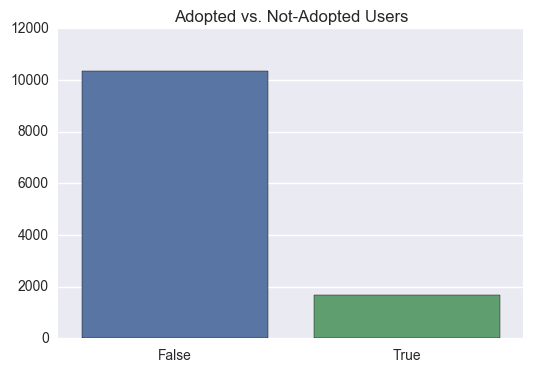

In [15]:
# Take another look at the distribution of the target class
sns.barplot(x = list(users_df['adopted'].value_counts().index), y = users_df['adopted'].value_counts())
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

Since this dataset is rather imbalanced, we have used the SMOTE algorithm in WEKA to oversample the data and enhance the presence of the True adopted user class. In addition, we have dropped any features that are used for identification or are in datetime format. We will read in the reduced dataset and explore the target class:

In [16]:
# Load in the newly SMOTE-d data and display
users_df_edit = pd.read_csv('users_WEKA_edit.csv')
users_df_edit.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1.0,0.0,11.0,False
1,ORG_INVITE,0.0,0.0,1.0,True
2,ORG_INVITE,0.0,0.0,94.0,False
3,GUEST_INVITE,0.0,0.0,1.0,False
4,GUEST_INVITE,0.0,0.0,193.0,False


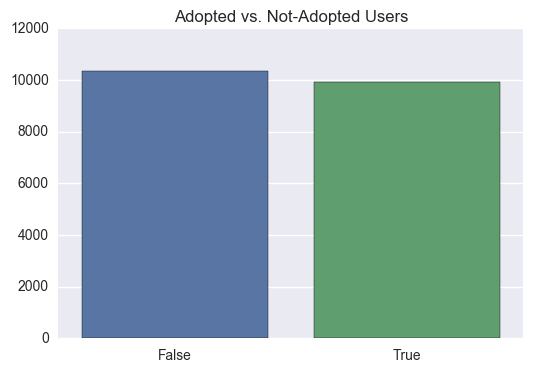

In [17]:
# Take a look at the distribution of the enhanced target class
sns.barplot(x = list(users_df_edit['adopted'].value_counts().index), 
            y = users_df_edit['adopted'].value_counts())
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

In [18]:
# Peak into the new data as a sanity check
users_df_edit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20280 entries, 0 to 20279
Data columns (total 5 columns):
creation_source               20280 non-null object
opted_in_to_mailing_list      20280 non-null float64
enabled_for_marketing_drip    20280 non-null float64
org_id                        20280 non-null float64
adopted                       20280 non-null bool
dtypes: bool(1), float64(3), object(1)
memory usage: 653.6+ KB


We will now continue by modeling the classification problem using a RandomForest classifier.  
  
Note: We will use the RandomForest classifier because it has yielded better baseline models compared to DecisionTree, k-nearest neighbors, logistic regression, and DecisionTree bagging.

In [19]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

/Users/WhoaaaItsDavid/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
# One-hot-encode creation_source
df_encoded = pd.get_dummies(users_df_edit, columns = ['creation_source'])

df_encoded.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.0,0.0,11.0,False,1,0,0,0,0
1,0.0,0.0,1.0,True,0,1,0,0,0
2,0.0,0.0,94.0,False,0,1,0,0,0
3,0.0,0.0,1.0,False,1,0,0,0,0
4,0.0,0.0,193.0,False,1,0,0,0,0


In [21]:
# Split into train and test sets

train, test = train_test_split(df_encoded, test_size=.30, 
                               random_state=42, stratify=df_encoded['adopted'])

train.reset_index(drop=True, inplace=True)
target = train['adopted']
train = train.drop('adopted', axis=1)

test.reset_index(drop=True, inplace=True)
test_target = test['adopted']
test = test.drop('adopted', axis=1)

print('Train shape: {}\n Test shape: {}'.format(train.shape, test.shape))

Train shape: (14196, 8)
 Test shape: (6084, 8)


In [22]:
# Perform cross validation on the training set

clf = RandomForestClassifier()

cv = cross_validation.KFold(len(train), n_folds=10)

cv_count = 1
for traincv, testcv in cv:  
        preds = clf.fit(train.loc[list(traincv),:], 
                        target.loc[list(traincv),]).predict(train.loc[list(testcv),:])
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.loc[testcv,], preds)

        print('Round {} CV\nAccuracy: {:.2f}\nAUC: {:.4f}\nConfusion Matrix:\n{}\n\n'\
                  .format(cv_count, accuracy_score(target.loc[testcv,], preds)*100, 
                          auc(false_positive_rate, true_positive_rate),
                          confusion_matrix(target.loc[testcv,], preds)))
        cv_count += 1

Round 1 CV
Accuracy: 80.85
AUC: 0.8064
Confusion Matrix:
[[640  91]
 [181 508]]


Round 2 CV
Accuracy: 80.56
AUC: 0.8051
Confusion Matrix:
[[609 111]
 [165 535]]


Round 3 CV
Accuracy: 82.18
AUC: 0.8190
Confusion Matrix:
[[655  85]
 [168 512]]


Round 4 CV
Accuracy: 80.14
AUC: 0.7992
Confusion Matrix:
[[647  80]
 [202 491]]


Round 5 CV
Accuracy: 79.51
AUC: 0.7942
Confusion Matrix:
[[618 101]
 [190 511]]


Round 6 CV
Accuracy: 82.46
AUC: 0.8240
Confusion Matrix:
[[645  71]
 [178 526]]


Round 7 CV
Accuracy: 79.70
AUC: 0.7948
Confusion Matrix:
[[630 105]
 [183 501]]


Round 8 CV
Accuracy: 80.34
AUC: 0.8031
Confusion Matrix:
[[602 112]
 [167 538]]


Round 9 CV
Accuracy: 81.75
AUC: 0.8165
Confusion Matrix:
[[628  94]
 [165 532]]


Round 10 CV
Accuracy: 81.18
AUC: 0.8111
Confusion Matrix:
[[633  84]
 [183 519]]




In [23]:
# Train the model on the full training data and test on the test set
final_clf = clf.fit(train, target)


test_preds = final_clf.predict(test)


print('Test set accuracy: {:.2f}\nConfusion Matrix:\n{}'\
          .format(accuracy_score(test_target, test_preds)*100, 
                  confusion_matrix(test_target, test_preds)))

Test set accuracy: 81.66
Confusion Matrix:
[[2739  364]
 [ 752 2229]]


In [24]:
# Find feature importances
feature_importance = pd.DataFrame(final_clf.feature_importances_).T
feature_importance.columns = list(train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
org_id,0.564503
opted_in_to_mailing_list,0.208159
enabled_for_marketing_drip,0.118562
creation_source_PERSONAL_PROJECTS,0.065042
creation_source_SIGNUP_GOOGLE_AUTH,0.019527
creation_source_ORG_INVITE,0.012991
creation_source_SIGNUP,0.007107
creation_source_GUEST_INVITE,0.004110
